# Terrassa Buildings Visual Search 2019

Notebook created by [Eva Mohedano](https://www.youtube.com/watch?v=SsHohytl1NA&feature=emb_logo) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2020).


Related [slides](https://www.slideshare.net/xavigiro/d1l5-contentbased-image-retrieval-upc-2018-deep-learning-for-computer-vision) and [video](https://www.youtube.com/watch?v=UyEXEGevhZs) from [Deep Learning for Computer Vision UPC TelecomBCN 2018](https://telecombcn-dl.github.io/2018-dlcv/)

![Eva Mohedano](https://telecombcn-dl.github.io/2018-dlcv/img/instructors/EvaMohedano.jpg)

This is a code example to perform retrieval in the training partition provided in the [kaggle 2019 competition](https://www.kaggle.com/c/terrassa-buildings-2019/data).

The notebook contains:


1.   Making data accessible for colab
2.   Setting pytorch Dataset
1.   Feature extraction with pre-trained model
2.   Ranking generation
1.   Performance evaluation
2.   Network fine-tuning


In [0]:
%pylab inline
import os

import numpy as np

from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import torch
from torch import nn

Populating the interactive namespace from numpy and matplotlib


##1) Making data accessible for colab

First we get the data from the [kaggle 2019 competition](https://www.kaggle.com/c/terrassa-buildings-2019/data) and make it accessible for the colab notebook.

For that, we have to upload the following files to our googledrive:
*   "database.txt"
*   "database.zip"
*   "queries.zip"

The we mount our googledrive folder to the colab workspace (this will require user authentification):

In [0]:
from google.colab import drive 
drive.mount('mydrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at mydrive


Here we make sure we find the relevant data, in this example the data is located in the following path:

In [0]:
! ls "/content/mydrive/My Drive/terrassa_buildings_2019/"

database.txt  database.zip  queries.zip


The last step consits in decompress the folders to the current workspace:

In [0]:
!unzip -qq "/content/mydrive/My Drive/terrassa_buildings_2019/database.zip" 

In [0]:
!unzip -qq "/content/mydrive/My Drive/terrassa_buildings_2019/queries.zip" 

In [0]:
!cp "/content/mydrive/My Drive/terrassa_buildings_2019/database.txt" . 

##2) Setting pytorch Dataset

In this section we implement a pytorch [Dataset class](https://pytorch.org/docs/stable/data.html#) to load the images from the challenge.

The training partition (names "dataset" in kaggle), convinently contains the class annotations of the buildings in the "dataset.txt" file. Well implement the class *BuildingsDataset* that will return in the "__getitem__" method a loaded image, its class id, and the name of the filename. Also, we'll generate a training/validation partition of the data (80% training /20% partition).


In [0]:
class BuildingsDataset(Dataset):
  def __init__(self, mode='training', seed=1234, transform=None):
    data = np.loadtxt("database.txt", dtype='str')
    path_images = "database/database"

    image_id = data[1:,0]
    class_name = data[1:,1]

    # convert string of class names into int
    unique_class_name = np.unique(class_name)
    unique_class_name.sort()
    dic_class={}
    for i, name in enumerate(unique_class_name):
      dic_class[name]=i

    labels = np.array([dic_class[n] for n in class_name])

    # generate partition 20/80%
    idx = np.arange(labels.shape[0])
    np.random.seed(seed)
    np.random.shuffle(idx)


    N = idx.shape[0]
    N_train = int(0.8*N)

    if mode=='training':
      idx = idx[:N_train]
    else:
      idx = idx[N_train:]

    # keep important info
    self.path_images = path_images
    self.image_id = image_id[idx]
    self.labels = labels[idx]
    self.dic_class = dic_class
    self.transform = transform
  
  def __getitem__(self,index):
    filename = os.path.join(self.path_images, self.image_id[index]+'.jpg')
    label = self.labels[index]
    name = self.image_id[index]

    # load image
    image = Image.open(filename)
    image = image.convert('RGB')

    # apply transforms
    if self.transform is not None:
      image = self.transform(image)

    return image, label, name
  
  def __len__(self):
    return self.labels.shape[0]


If we want to use a imagenet pre-trained model, we will have to pre-process the images do they are compatible with the network.
Basically, we'll have to make sure that all images have a consisent shape (224,224) and are normalize according with the ImageNet statistics.

The image transforms, using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) library are the following:

In [0]:
image_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

##3) Feature extraction with pretrained model

Now that we have the data ready to read, we use a pretrained model from torchvision. This library have a variety of already trained models, you can check them [here](https://pytorch.org/docs/stable/torchvision/models.html).

For the experiments, we select a resnet50 from the catalog:


```
from torchvision.models import resnet50
```



In [0]:
model = resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 336MB/s]


We'll extract features from the layer before the classification. For that, we have to remove the last fully connected layer. We can do that by creating a new sequential model that includes all the original layers of the pre-trained resnet50, except the last one:

In [0]:
fx_model = nn.Sequential(*list(model.children())[:-1])
fx_model.eval()
fx_model.cuda()
print("Pretrained resnet50 feature extractor")

Pretrained resnet50 feature extractor


Some utility feature extraction functions:

In [0]:
def convert_to_numpy(tensor):
  if tensor.is_cuda:
    data = tensor.data.cpu().numpy()
  else:
    data = tensor.data.numpy()
  return data

def extract_features(dataloader, model):
  '''

  Functions that extract feature vectors for all the images contained in a 
  pytorch Dataloader.

  args:
    dataloader: torch.data.Dataloader object returning (images, labels, image_name)
    model:feature extractor pytorch model
  returns:
    all_features: numpy array (n_sample, feat_dim)
    all_labels: list (n_sample)
    all_names: list (all_names)
  '''
  model.eval()

  all_features=[]
  all_labels=[]
  all_names=[]

  for i, batch in tqdm(enumerate(dataloader)):
    x = batch[0]
    x = x.cuda()
    y = batch[1]
    name = batch[2]

    batch_feats = model.forward(x).squeeze()
    batch_feats_np = convert_to_numpy(batch_feats)
    batch_y_np = convert_to_numpy(y)

    all_features.extend(batch_feats_np)
    all_labels.extend(batch_y_np)
    all_names.extend(name)
  
  all_features = np.array(all_features)
  return all_features, all_labels, all_names

We'll create a [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) based on the Dataset partitions defined in our *BuildingsDataset* class that will allow us to create batches of data. In this example we use a batch size of 50 samples:

In [0]:
ds_train = BuildingsDataset('training', transform=image_transforms)
ds_val = BuildingsDataset('validation', transform=image_transforms)

dataloader ={
  'training':DataLoader(ds_train,batch_size=50, shuffle=False, num_workers=5),
  'validation':DataLoader(ds_val,batch_size=50, shuffle=False, num_workers=5)}

Now we compute the features for the training and validation sets:

In [0]:
for mode  in ['training', 'validation']:
  print(f"Extracting features for {mode}")
  loader = dataloader[mode]
  if mode=='training':
    ds_features, ds_labels, ds_names = extract_features(loader, fx_model)
  else:
    query_features, query_labels, query_names = extract_features(loader, fx_model)


print("\nTraining dimensions: ", ds_features.shape)
print("\nValidation dimensions: ", query_features.shape)

Extracting features for training


33it [00:05,  5.76it/s]

Extracting features for validation



9it [00:01,  5.13it/s]


Training dimensions:  (1648, 2048)

Validation dimensions:  (413, 2048)


(We are using the validation set as query set so later we can evaluate the performance of the retrieval system)

##4) Ranking generation

Now that we have extracted features for our training and validation set (used as dataset and query partitions), we can generated a ranked list of the images in the training (dataset) for each image of the query (validation) set.

We'll us pytorch tensors for the similarity ang rank generation:

In [0]:
ds_features = torch.Tensor(ds_features)
ds_labels = torch.Tensor(ds_labels)
query_features = torch.Tensor(query_features)


The similarity score between two image representations  $\textbf{x}$ and $\textbf{y} $ 
is given by
$$sim_{\textbf{x},\textbf{y}} = \textbf{x}\cdot \textbf{y}^T $$

However, if we want to obtain a score $\in [0,1]$ we must l2-normalize each ima representation:
    $$ \textbf{x}_{l_{2}norm} = \frac{\textbf{x}}{||\textbf{x}||}$$


In [0]:
def l2norm(tensor):
  norm = torch.sqrt(torch.sum(tensor**2, axis=1))
  return tensor/norm[:,None]

def generate_rankings(ds_features, query_features):
  '''

  Function for ranking generation given dataset and query features.

  args:
    ds_features: pytorch tensor (n_dataset, feat_dim)
    query_features: pytorch tensor (n_query, feat_dim)
  returns:
    ranks_id: sorted dataser indices (n_query,n_dataset)
  '''

  dataset = l2norm(ds_features)
  queries = l2norm(query_features)

  # similarities
  similaritites = torch.mm(queries, dataset.t()).squeeze()

  # rank from more to less similar
  ranks_id = torch.argsort(similaritites, dim=-1, descending=True)
  return ranks_id

In [0]:
ranks_id_fx_model = generate_rankings(ds_features, query_features)
ranks_id_fx_model.size()

torch.Size([413, 1648])

Qualitative results of 5 queries:

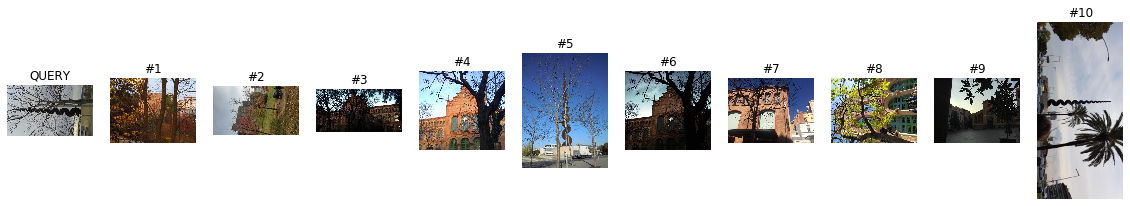

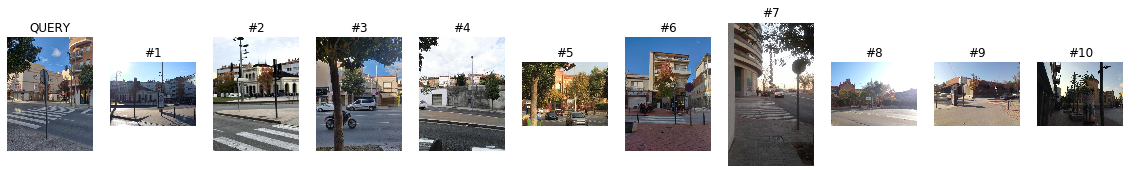

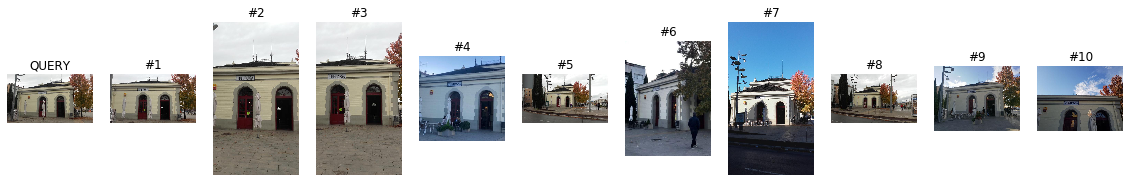

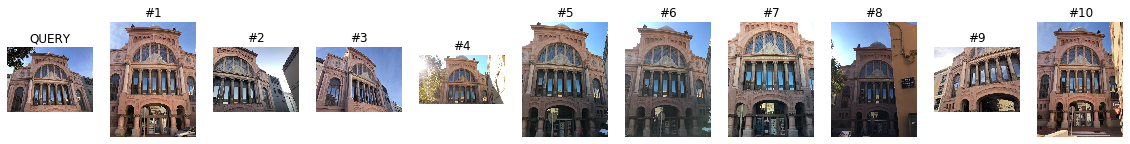

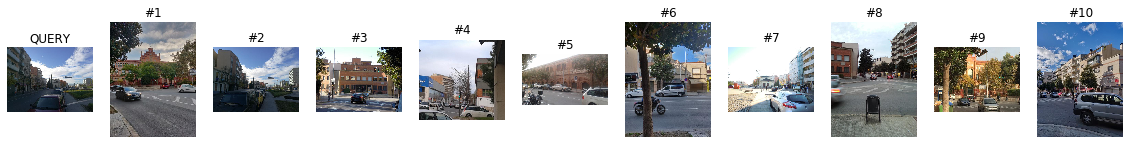

In [0]:
ds_query = BuildingsDataset('valitation', transform=None)
ds_dataset = BuildingsDataset('training', transform=None)

def show_rank(ds_query, ds_dataset,ranks_id, id_query=0):
  figsize(20,20)
  title("Top-10 mods_labelsst similar results")
  subplot(1,11,1), imshow(ds_query[id_query][0])
  title('QUERY')
  axis('off')


  for i, id in enumerate(ranks_id[id_query][:10]): # We disply from the second result because the query is included in the DS
    subplot(1,11,i+2), imshow(ds_dataset[id][0])
    title(f'#{i+1}')
    axis('off')
    
  show()

for i in range(5):
  idx_query=np.random.randint(0,len(ds_query))
  show_rank(ds_query, ds_dataset,ranks_id_fx_model, id_query=idx_query)


##5) Performance evaluation

We will calculate the **mean Averace Precision (mAP)** of a set of queries given by
$$ mAP = \frac{1}{N}\sum_{j}^{N}\frac{1}{Q_{j}}\sum_{i=1}^{Q_{j}}P(doc_{i})$$

where $Q_{j}$ is the  number of relevant documents for query $j$, $N$ is number of queries, $P(doc_{i} )$ is the precision at $i$th relevant document. The example below ilustrates the Average Precision scores associated to the ranked retrieved results of two queries (Examples taken from [Simone Teufel lecture slides, Lecture 5: Information Retrieval](https://www.cl.cam.ac.uk/teaching/1415/InfoRtrv/lecture5.pdf))

In [0]:
def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

In [0]:
def compute_map(ds_labels, query_labels, ranks_id):
  ap_queries=[] 
  for i, label in enumerate(query_labels):
    # show_rank(ds_query, ds_dataset,ranks_id, id_query=i)

    labels_dataset_ranked = ds_labels[ranks_id[i]]
    rank = torch.zeros_like(labels_dataset_ranked)
    rank[labels_dataset_ranked==label]=1

    rank = convert_to_numpy(rank)
    ap=average_precision(rank)

    ap_queries.append(ap)

  return np.mean(ap_queries)

In [0]:
mAp = compute_map(ds_labels, query_labels, ranks_id_fx_model)
print(f"Pre-trained features achieve {mAp} mAP")

Pre-trained features achieve 0.38796389357602895 mAP


##6) Netwok fine-tuning

In [0]:
model = resnet50(pretrained=True, progress=True)

In [0]:
model.fc=nn.Linear(2048,13)
model = model.cuda()
print("modified resnet50 for Terrassa Buildings")

modified resnet50 for Terrassa Buildings


In [0]:
optimizer = torch.optim.Adam(model.parameters())
cross_entropy = nn.CrossEntropyLoss()

In [0]:
ds_train = BuildingsDataset('training', transform=image_transforms)
ds_val = BuildingsDataset('validation', transform=image_transforms)

dataloader ={
  'training':DataLoader(ds_train,batch_size=50, shuffle=True, num_workers=5), # note we randomize the order of the features!
  'validation':DataLoader(ds_val,batch_size=50, shuffle=False, num_workers=5)}

In [0]:
def compute_accuracy(pred, y):
  id_pred = torch.argmax(nn.Softmax(dim=-1)(pred), dim=-1)
  return float((id_pred==y).sum())/id_pred.size()[0]


In [0]:
total_epochs=0

In [0]:
for epoch in range(20):
  for mode  in ['training', 'validation']:
    loss_epoch=[]
    acc_epoch=[]

    if mode=='training':
      model.train()
      total_epochs+=1
    else:
      model.eval()

    loader = dataloader[mode]

    for i, (x,y,names) in enumerate(loader):
      x=x.cuda()
      y=y.cuda()
      pred = model.forward(x)
      loss = cross_entropy(pred, y.long())
      acc = compute_accuracy(pred, y)

      if mode=='training':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # print(i, loss.item(), acc)
      loss_epoch.append(loss.item())
      acc_epoch.append(acc)
    loss_epoch = np.mean(loss_epoch)
    acc_epoch = np.mean(acc_epoch)
    

    print(f"{total_epochs}, {mode}, {loss_epoch}, {acc_epoch}")

1, training, 1.2208585666887688, 0.623838383838384
1, validation, 4.016675233840942, 0.37572649572649575
2, training, 0.6710813000346675, 0.789469696969697
2, validation, 7.0982429186503095, 0.44649572649572655
3, training, 0.5762746397292975, 0.8203787878787878
3, validation, 1.363210015826755, 0.7273504273504273
4, training, 0.3808109669974356, 0.8852777777777778
4, validation, 0.7568341824743483, 0.7432478632478632
5, training, 0.29852188830122806, 0.9047979797979797
5, validation, 1.3258299430211384, 0.6680341880341881
6, training, 0.2751382772218097, 0.9088131313131312
6, validation, 2.2087833219104342, 0.5905982905982905
7, training, 0.26417204410289274, 0.914469696969697
7, validation, 1.9818226099014282, 0.606153846153846
8, training, 0.2532867184755477, 0.9174747474747474
8, validation, 0.8312949273321364, 0.7984615384615384
9, training, 0.2406635121865706, 0.9205555555555555
9, validation, 1.3201552265220218, 0.7358974358974358
10, training, 0.26197257976640353, 0.92174242424

KeyboardInterrupt: ignored

In [0]:
# optionally save the model
torch.save(model.state_dict(), 'trained_valacc_XXX.pt')

###All retrieval pipeline with the fine-tuned model:

In [0]:
# Feature extraction
fx_model_finetuned = nn.Sequential(*list(model.children())[:-1])
fx_model_finetuned.eval()
fx_model_finetuned.cuda()
print("pretrained fx")

for mode  in ['training', 'queries']:
  print(f"Extracting features for {mode}")
  ds = BuildingsDataset(mode, transform=image_transforms)
  dataloader = DataLoader(ds,batch_size=50, shuffle=False, num_workers=5)
  if mode=='training':
    ds_features, ds_labels, ds_names = extract_features(dataloader, fx_model_finetuned)
  else:
    query_features, query_labels, query_names = extract_features(dataloader, fx_model_finetuned)

pretrained fx
Extracting features for training


33it [00:05,  5.78it/s]

Extracting features for queries



9it [00:01,  5.22it/s]


In [0]:
# conversion to torch
ds_features = torch.Tensor(ds_features)
ds_labels = torch.Tensor(ds_labels)
query_features = torch.Tensor(query_features)

# generate ranks
ranks_id_finetuned = generate_rankings(ds_features, query_features)

# quantitaive evaluation
mAp = compute_map(ds_labels, query_labels, ranks_id_finetuned)
print(f"Fine-tuned features achieve {mAp} mAP")

Fine-tuned features achieve 0.8568809826781841 mAP
